In [1]:
import os
import keras
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
import requests
import shutil
import urllib
import math

# for notification after long-running code-cell
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

#Now let us read metadata to get our Y values (multiple lables)
os.chdir("/Users/jonas/Documents/art-classification/")
df = pd.read_csv('data/wikiart_scraped.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)
#print(df["Style"].unique())

styles = ["Abstract-Art", "Abstract-Expressionism", "Academicism", "Art-Informel", "Art-Nouveau-(Modern)", "Baroque","Cubism", "Color-Field-Painting", "Conceptual-Art", "Expressionism", "Impressionism", "Mannerism-(Late-Renaissance)", "Minimalism", "Naïve-Art-(Primitivism)", "Pop-Art", "Post-Impressionism", "Neoclassicism", "Neo-Expressionism", "Northern-Renaissance", "Realism", "Rococo", "Romanticism", "Surrealism", "Symbolism"]

df = df[df["Style"].isin(styles)]
print(df.iloc[:20])

print(df.shape)



#save images
main_dir = os.getcwd()
image_directory = os.getcwd()+"/data/img"#/new"
os.chdir(image_directory)

""" Test for a single image
img_url = "https://uploads3.wikiart.org/00265/images/ancient-egyptian-painting/narmer-palette.jpg"
img = Image.open(requests.get(img_url, stream = True).raw)
img = img.resize((300,300))
img.save("bla.jpg")
"""
"""
ImageFile.LOAD_TRUNCATED_IMAGES = True # especially in Cubism there are truncated files
for index, row in df.iterrows():
    if not os.path.exists(str(index) + ".jpg"):
        try:
            img = Image.open(requests.get(row["Link"], stream=True).raw)
            img = img.resize((300, 300))
            img.convert("RGB").save(str(index) + ".jpg")
        except:
            print("An error occured with image {} (Link: {})".format(index, row["Link"]))
Audio(wave, rate=10000, autoplay=True) # notification that execution is finished
"""

            Style                                    Artwork         Artist  \
0  Early-Dynastic                             Narmer Palette  Ancient Egypt   
1  Early-Dynastic         Box Inlay with a Geometric Pattern  Ancient Egypt   
2     Old-Kingdom                           Khafre Enthroned  Ancient Egypt   
3  Middle-Kingdom  Stele of the Serpent King (Stela of Djet)  Ancient Egypt   
4  Middle-Kingdom  Laden Donkeys and Ploughing, Tomb of Djar  Ancient Egypt   

           Date                                               Link  
0       3050 BC  https://uploads3.wikiart.org/00265/images/anci...  
1  3100-2900 BC  https://uploads2.wikiart.org/00244/images/anci...  
2       2570 BC  https://uploads2.wikiart.org/00305/images/anci...  
3       3000 BC  https://uploads7.wikiart.org/00305/images/anci...  
4  2060-2010 BC  https://uploads8.wikiart.org/00244/images/anci...  
Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')
                             Style       

'\nImageFile.LOAD_TRUNCATED_IMAGES = True # especially in Cubism there are truncated files\nfor index, row in df.iterrows():\n    if not os.path.exists(str(index) + ".jpg"):\n        try:\n            img = Image.open(requests.get(row["Link"], stream=True).raw)\n            img = img.resize((300, 300))\n            img.convert("RGB").save(str(index) + ".jpg")\n        except:\n            print("An error occured with image {} (Link: {})".format(index, row["Link"]))\nAudio(wave, rate=10000, autoplay=True) # notification that execution is finished\n'

In [2]:

df = df[df.Date.str.isnumeric()] # only accept numeric dates
df["Date"] = pd.to_numeric(df["Date"])
df = df[df["Date"]>=1000]
#timedelta = 10
#timesteps = range(1000, 2020, 10)

# bring style to correct format
"""
for style in styles:
    df[style] = 0 #1 if (df["Style"]==style) else 0
    df.loc[df["Style"]==style, style] = 1
"""

# split into decades / other defined timedelta

# exact year to decade
df["Date"] = df["Date"].apply(lambda x: (math.floor(x/10))*10)

df=pd.get_dummies(df, columns=["Style", "Date"])

df["id"] = df.index
#df["idx"] = df["idx"].astype(str) + ".jpg"
#print(df)

"""
for time in timesteps:
    df[str(time)+"s"]=0
"""

"""
for index, row in df.iterrows():
    found = False
    for time in timesteps:
        if math.floor((row["Date"]/10)*10) == time:
            row[str(time)+"s"] = 1
"""

'\nfor index, row in df.iterrows():\n    found = False\n    for time in timesteps:\n        if math.floor((row["Date"]/10)*10) == time:\n            row[str(time)+"s"] = 1\n'

In [3]:
""" Takes way too much memory
SIZE = 200
X_dataset = []
#for i in tqdm(range(df.shape[0])):
for index, row in df.iterrows():
    img = image.image_utils.load_img(image_directory + "/" + str(index) + '.jpg', target_size=(SIZE,SIZE,3))
    img = image.image_utils.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    #df.loc[index,str(row["Date"])+"s"]=1 # to_categorical would have been the easy solution


X = np.array(X_dataset)
"""
X = np.array(df["id"])

In [4]:


#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
#y = np.array(df.drop(['Style', 'Artwork', 'Artist', 'Date', 'Link'], axis=1))
y = np.array(df.drop(['Artwork', 'Artist', 'Link', 'id'], axis=1))
print(len(y))
print(y)

58249
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [5]:
import tensorflow as tf

os.chdir(main_dir+"/models")
csv_logger = tf.keras.callbacks.CSVLogger(os.getcwd()+"/history_style.csv", separator=",", append=True)
decades = [col for col in df if col.startswith("Date_")]
print(decades)

['Date_1410', 'Date_1420', 'Date_1430', 'Date_1440', 'Date_1450', 'Date_1460', 'Date_1470', 'Date_1480', 'Date_1490', 'Date_1500', 'Date_1510', 'Date_1520', 'Date_1530', 'Date_1540', 'Date_1550', 'Date_1560', 'Date_1570', 'Date_1580', 'Date_1590', 'Date_1600', 'Date_1610', 'Date_1620', 'Date_1630', 'Date_1640', 'Date_1660', 'Date_1670', 'Date_1680', 'Date_1690', 'Date_1700', 'Date_1710', 'Date_1720', 'Date_1730', 'Date_1740', 'Date_1750', 'Date_1760', 'Date_1770', 'Date_1780', 'Date_1790', 'Date_1800', 'Date_1810', 'Date_1820', 'Date_1830', 'Date_1840', 'Date_1850', 'Date_1860', 'Date_1870', 'Date_1880', 'Date_1890', 'Date_1900', 'Date_1910', 'Date_1920', 'Date_1930', 'Date_1940', 'Date_1950', 'Date_1960', 'Date_1970', 'Date_1980', 'Date_1990', 'Date_2000', 'Date_2010', 'Date_2020']


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

#X_train_df = pd.DataFrame(X_train, columns=["name"])
#X_test_df = pd.DataFrame(X_test, columns=["name"])
train_df = df.loc[X_train].drop(['Artwork', 'Artist', 'Link'], axis=1)
train_df["id"] = train_df["id"].astype(str) + ".jpg"
test_df = df.loc[X_test].drop(['Artwork', 'Artist', 'Link'], axis=1)
test_df["id"] = test_df["id"].astype(str) + ".jpg"

style_labels = [col for col in df if (col.startswith("Style_"))]
labels = [col for col in df if (col.startswith("Date_") or col.startswith("Style_"))]

print(y_train)
#print(train_df)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
#import splitfolders
#splitfolders.ratio(image_directory, output=image_directory, seed=1337, ratio=(.7, 0.15,0.15))

In [16]:
from keras import Input
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
newModel = False
continue_training = True

SIZE = 200
epochs = 10
batch_size = 64

train_loss = [] # to append when training in batches
train_acc_style = []
train_acc_decade = []


def load_images(names):
    X_dataset = []
    for name in names:
        img = image.image_utils.load_img(image_directory + "/" + str(name) + '.jpg', target_size=(SIZE,SIZE,3))
        img = image.image_utils.img_to_array(img)
        img = img/255.
        X_dataset.append(img)
    return np.array(X_dataset)

datagen=ImageDataGenerator(rescale=1./255)
train_generator_style=datagen.flow_from_dataframe(dataframe=train_df, directory=image_directory, x_col="id", y_col=style_labels, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
test_generator_style=datagen.flow_from_dataframe(dataframe=test_df, directory=image_directory, x_col="id", y_col=style_labels, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)

if newModel:

    input_layer = Input(shape=(SIZE,SIZE,3))

    conv1 = Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_layer)
    bn1 = BatchNormalization()(conv1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    dropout1 = Dropout(0.2)(mp1)

    conv2 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(dropout1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    bn2 = BatchNormalization()(mp2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(dropout2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    bn3 = BatchNormalization()(mp3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(dropout3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    bn4 = BatchNormalization()(mp4)
    dropout4 = Dropout(0.2)(bn4)

    flatten = Flatten()(dropout4)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout5 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout5)
    dropout6 = Dropout(0.5)(dense2)

    y1_output = Dense(len(styles), activation='softmax', name='style_output')(dropout6)
    y2_output = Dense(len(decades), activation='softmax', name='decade_output')(dropout6)
    #model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    model = keras.Model(inputs=input_layer, outputs=y1_output)

    model.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator_style,
                        epochs=epochs,
                        validation_data=test_generator_style,
                        batch_size=batch_size,
                        callbacks=[csv_logger])
    """

    for epoch in range(epochs):
        idx = 0
        while idx+batch_size < len(X_train):
            history = model.fit(load_images(X_train[idx:idx+batch_size]),
                            [y_train[idx:idx+batch_size,0:len(styles)], y_train[idx:idx+batch_size,len(styles):]],
                            validation_data=(load_images(X_test[idx:idx+batch_size]), [y_test[idx:idx+batch_size,0:len(styles)], y_test[idx:idx+batch_size,len(styles):]])#,
                            #callbacks=[csv_logger]
                            )
            train_loss.append(history.history['loss'])
            train_acc_style.append(history.history['style_output_accuracy'])
            train_acc_decade.append(history.history['decade_output_accuracy'])
            idx+=batch_size
        # as training set might not be a multiple of batch size: train for the last images
        history = model.fit(load_images(X_train[idx:]),
                            [y_train[idx:,0:len(styles)], y_train[idx:,len(styles):]],
                            validation_data=(load_images(X_test[idx:]), [y_test[idx:,0:len(styles)], y_test[idx:,len(styles):]])
                            #,callbacks=[csv_logger]
                            )
        train_loss.append(history.history['loss'])
        train_acc_style.append(history.history['style_output_accuracy'])
        train_acc_decade.append(history.history['decade_output_accuracy'])
    """

    # save model
    !mkdir -p style
    model.save('style/only_style')

else:
    model = keras.models.load_model('style/continued')
    if continue_training:
        datagen=ImageDataGenerator(rescale=1./255)
        train_generator_style=datagen.flow_from_dataframe(dataframe=train_df, directory=image_directory, x_col="id", y_col=style_labels, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
        test_generator_style=datagen.flow_from_dataframe(dataframe=test_df, directory=image_directory, x_col="id", y_col=style_labels, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)

        history = model.fit(train_generator_style,
                            epochs=epochs,
                            validation_data=test_generator_style,
                            batch_size=batch_size,
                            callbacks=[csv_logger])
        #history = model.evaluate(X_test, y_test, verbose=2)
        #history.history=history

        model.save('style/continued2')

Found 40774 validated image filenames.
Found 17475 validated image filenames.
Epoch 1/10
638/638 [==============================] - 502s 785ms/step - loss: 0.1456 - accuracy: 0.2064 - val_loss: 0.1449 - val_accuracy: 0.2160
Epoch 2/10
638/638 [==============================] - 495s 776ms/step - loss: 0.1439 - accuracy: 0.2170 - val_loss: 0.1904 - val_accuracy: 0.1213
Epoch 3/10
638/638 [==============================] - 512s 802ms/step - loss: 0.1427 - accuracy: 0.2221 - val_loss: 0.1382 - val_accuracy: 0.2456
Epoch 4/10
638/638 [==============================] - 504s 790ms/step - loss: 0.1409 - accuracy: 0.2350 - val_loss: 0.1388 - val_accuracy: 0.2481
Epoch 5/10
638/638 [==============================] - 515s 807ms/step - loss: 0.1403 - accuracy: 0.2386 - val_loss: 0.1412 - val_accuracy: 0.2292
Epoch 6/10
638/638 [==============================] - 503s 788ms/step - loss: 0.1390 - accuracy: 0.2453 - val_loss: 0.1383 - val_accuracy: 0.2475
Epoch 7/10
638/638 [==========================

INFO:tensorflow:Assets written to: style/continued2/assets


INFO:tensorflow:Assets written to: style/continued2/assets


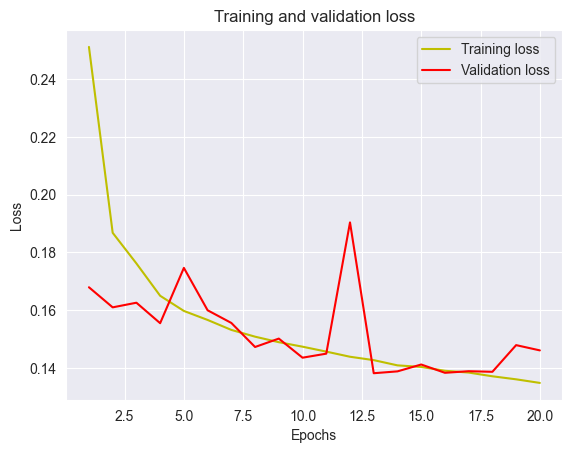

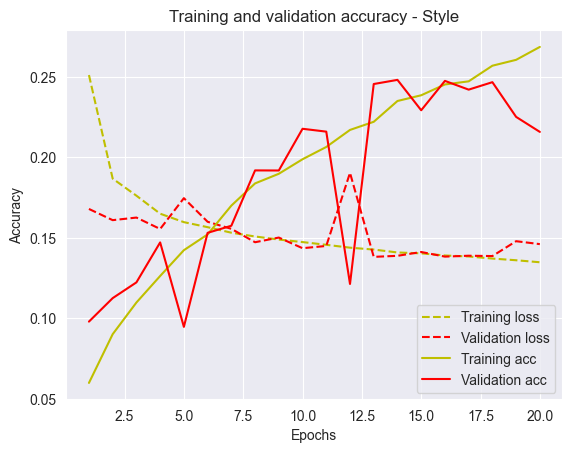

In [197]:
plot_with_loss=True
from_csv = True
filepath = "/Users/jonas/Documents/art-classification/models/style/history.csv"
if from_csv:
    history = pd.read_csv(filepath, header=None)
    # epoch (starts at 0 for each new training) | acc | loss | val_acc | val_loss
    #print(history)
    loss = np.array(history[2])
    val_loss = np.array(history[4])
    acc = np.array(history[1])
    val_acc = np.array(history[3])
else:
    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

if plot_with_loss:
    plt.plot(epochs, loss, 'y', label='Training loss', linestyle='dashed')
    plt.plot(epochs, val_loss, 'r', label='Validation loss', linestyle='dashed')
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Style')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
os.chdir(main_dir+"/models")
csv_logger2 = tf.keras.callbacks.CSVLogger(os.getcwd()+"/history_decades.csv", separator=",", append=True)

newModel = True
continue_training = False

SIZE = 200
epochs = 20
batch_size = 64

train_loss = [] # to append when training in batches
train_acc_style = []
train_acc_decade = []


def load_images(names):
    X_dataset = []
    for name in names:
        img = image.image_utils.load_img(image_directory + "/" + str(name) + '.jpg', target_size=(SIZE,SIZE,3))
        img = image.image_utils.img_to_array(img)
        img = img/255.
        X_dataset.append(img)
    return np.array(X_dataset)

datagen=ImageDataGenerator(rescale=1./255)
train_generator_decade=datagen.flow_from_dataframe(dataframe=train_df, directory=image_directory, x_col="id", y_col=decades, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
test_generator_decade=datagen.flow_from_dataframe(dataframe=test_df, directory=image_directory, x_col="id", y_col=decades, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)

if newModel:

    input_layer = Input(shape=(SIZE,SIZE,3))

    conv1 = Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_layer)
    bn1 = BatchNormalization()(conv1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    dropout1 = Dropout(0.2)(mp1)

    conv2 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(dropout1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    bn2 = BatchNormalization()(mp2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(dropout2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    bn3 = BatchNormalization()(mp3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(dropout3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    bn4 = BatchNormalization()(mp4)
    dropout4 = Dropout(0.2)(bn4)

    flatten = Flatten()(dropout4)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout5 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout5)
    dropout6 = Dropout(0.5)(dense2)

    y1_output = Dense(len(styles), activation='softmax', name='style_output')(dropout6)
    y2_output = Dense(len(decades), activation='softmax', name='decade_output')(dropout6)
    #model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    model2 = keras.Model(inputs=input_layer, outputs=y2_output)

    model2.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    history2 = model2.fit(train_generator_decade,
                        epochs=epochs,
                        validation_data=test_generator_decade,
                        batch_size=batch_size,
                        callbacks=[csv_logger2])

    # save model
    !mkdir -p decade
    model.save('decade/only_decade')

else:
    model2 = keras.models.load_model('decade/only_decade')
    if continue_training:
        datagen=ImageDataGenerator(rescale=1./255)
        train_generator_decades=datagen.flow_from_dataframe(dataframe=train_df, directory=image_directory, x_col="id", y_col=decades, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
        test_generator_decades=datagen.flow_from_dataframe(dataframe=test_df, directory=image_directory, x_col="id", y_col=decades, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)

        history2 = model2.fit(train_generator_decade,
                            epochs=epochs,
                            validation_data=test_generator_decade,
                            batch_size=batch_size,
                            callbacks=[csv_logger2])
        #history = model.evaluate(X_test, y_test, verbose=2)
        #history.history=history

        model2.save('decade/continued')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 196, 196, 16)      1216      
                                                                 
 batch_normalization_12 (Bat  (None, 196, 196, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 98, 98, 16)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 98, 98, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 94, 94, 32)        1283

INFO:tensorflow:Assets written to: decade/only_decade/assets


INFO:tensorflow:Assets written to: decade/only_decade/assets


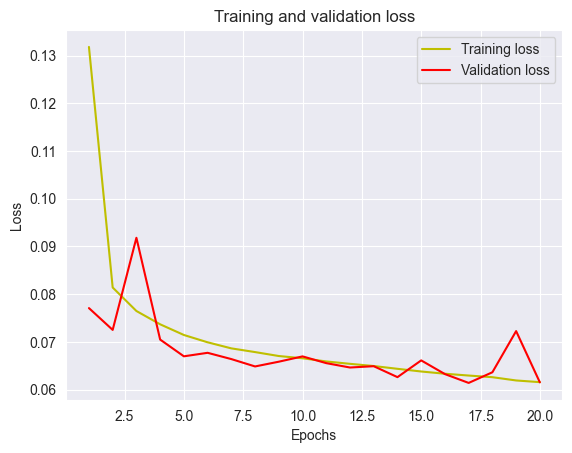

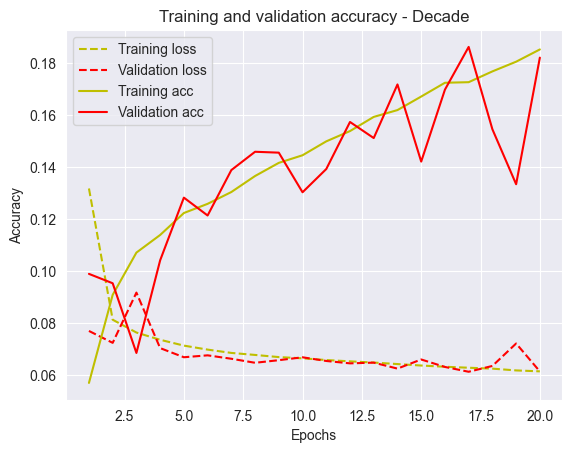

In [198]:
from_csv = False
filepath = "/Users/jonas/Documents/art-classification/models/decades/history.csv"
if from_csv:
    history = pd.read_csv(filepath, header=None)
    # epoch (starts at 0 for each new training) | acc | loss | val_acc | val_loss
    print(history)
    loss = np.array(history[2])
    val_loss = np.array(history[4])
    acc = np.array(history[1])
    val_acc = np.array(history[3])
else:
    #plot the training and validation accuracy and loss at each epoch
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']
    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

if plot_with_loss:
    plt.plot(epochs, loss, 'y', label='Training loss', linestyle='dashed')
    plt.plot(epochs, val_loss, 'r', label='Validation loss', linestyle='dashed')
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Decade')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step
Predicted style: Style_Symbolism, actual: Neo-Expressionism
Predicted decade: Date_1880, actual: 1998


'\n'

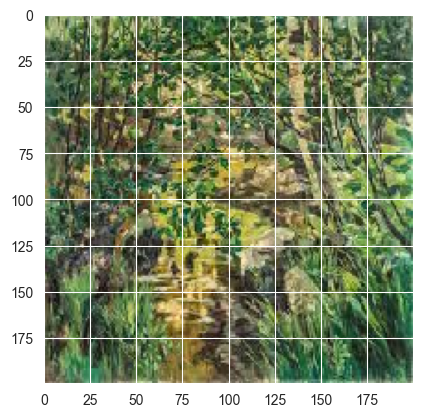

In [130]:
#################################################
#Validate on an image
#img = image.load_img('movie_dataset_multilabel/images/tt4425064.jpg', target_size=(SIZE,SIZE,3))
os.chdir("/Users/jonas/Documents/art-classification/test/")
image_idx = 98000
img = image.image_utils.load_img('hagemeister.jpeg', target_size=(SIZE,SIZE,3))

img = image.image_utils.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

pred_style = model.predict(img)
pred_decade = model2.predict(img)
df_original = pd.read_csv(main_dir+'/data/wikiart_scraped.csv')

print("Predicted style: {}, actual: {}".format(style_labels[pred_style.argmax()], df_original["Style"].loc[image_idx]))
print("Predicted decade: {}, actual: {}".format(decades[pred_decade.argmax()], df_original["Date"].loc[image_idx]))


###################################################

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

################################################################

"""
"""





In [32]:
print(df.loc[image_idx,:])

Artwork                                                          From Dominik
Artist                                                       Viktor Vasnetsov
Link                        https://uploads4.wikiart.org/images/viktor-vas...
Style_Baroque                                                               0
Style_Expressionism                                                         0
Style_Impressionism                                                         0
Style_Neoclassicism                                                         0
Style_Post-Impressionism                                                    0
Style_Realism                                                               1
Style_Romanticism                                                           0
Style_Surrealism                                                            0
Style_Symbolism                                                             0
Date_1580                                                       

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

style_predictions = model.predict(load_images(X_test))
cm_style = confusion_matrix(y_test[:, 0:len(style_labels)].argmax(axis=1),style_predictions.argmax(axis=1))
print(cm_style)

17475
17475


(-0.5, 23.5)

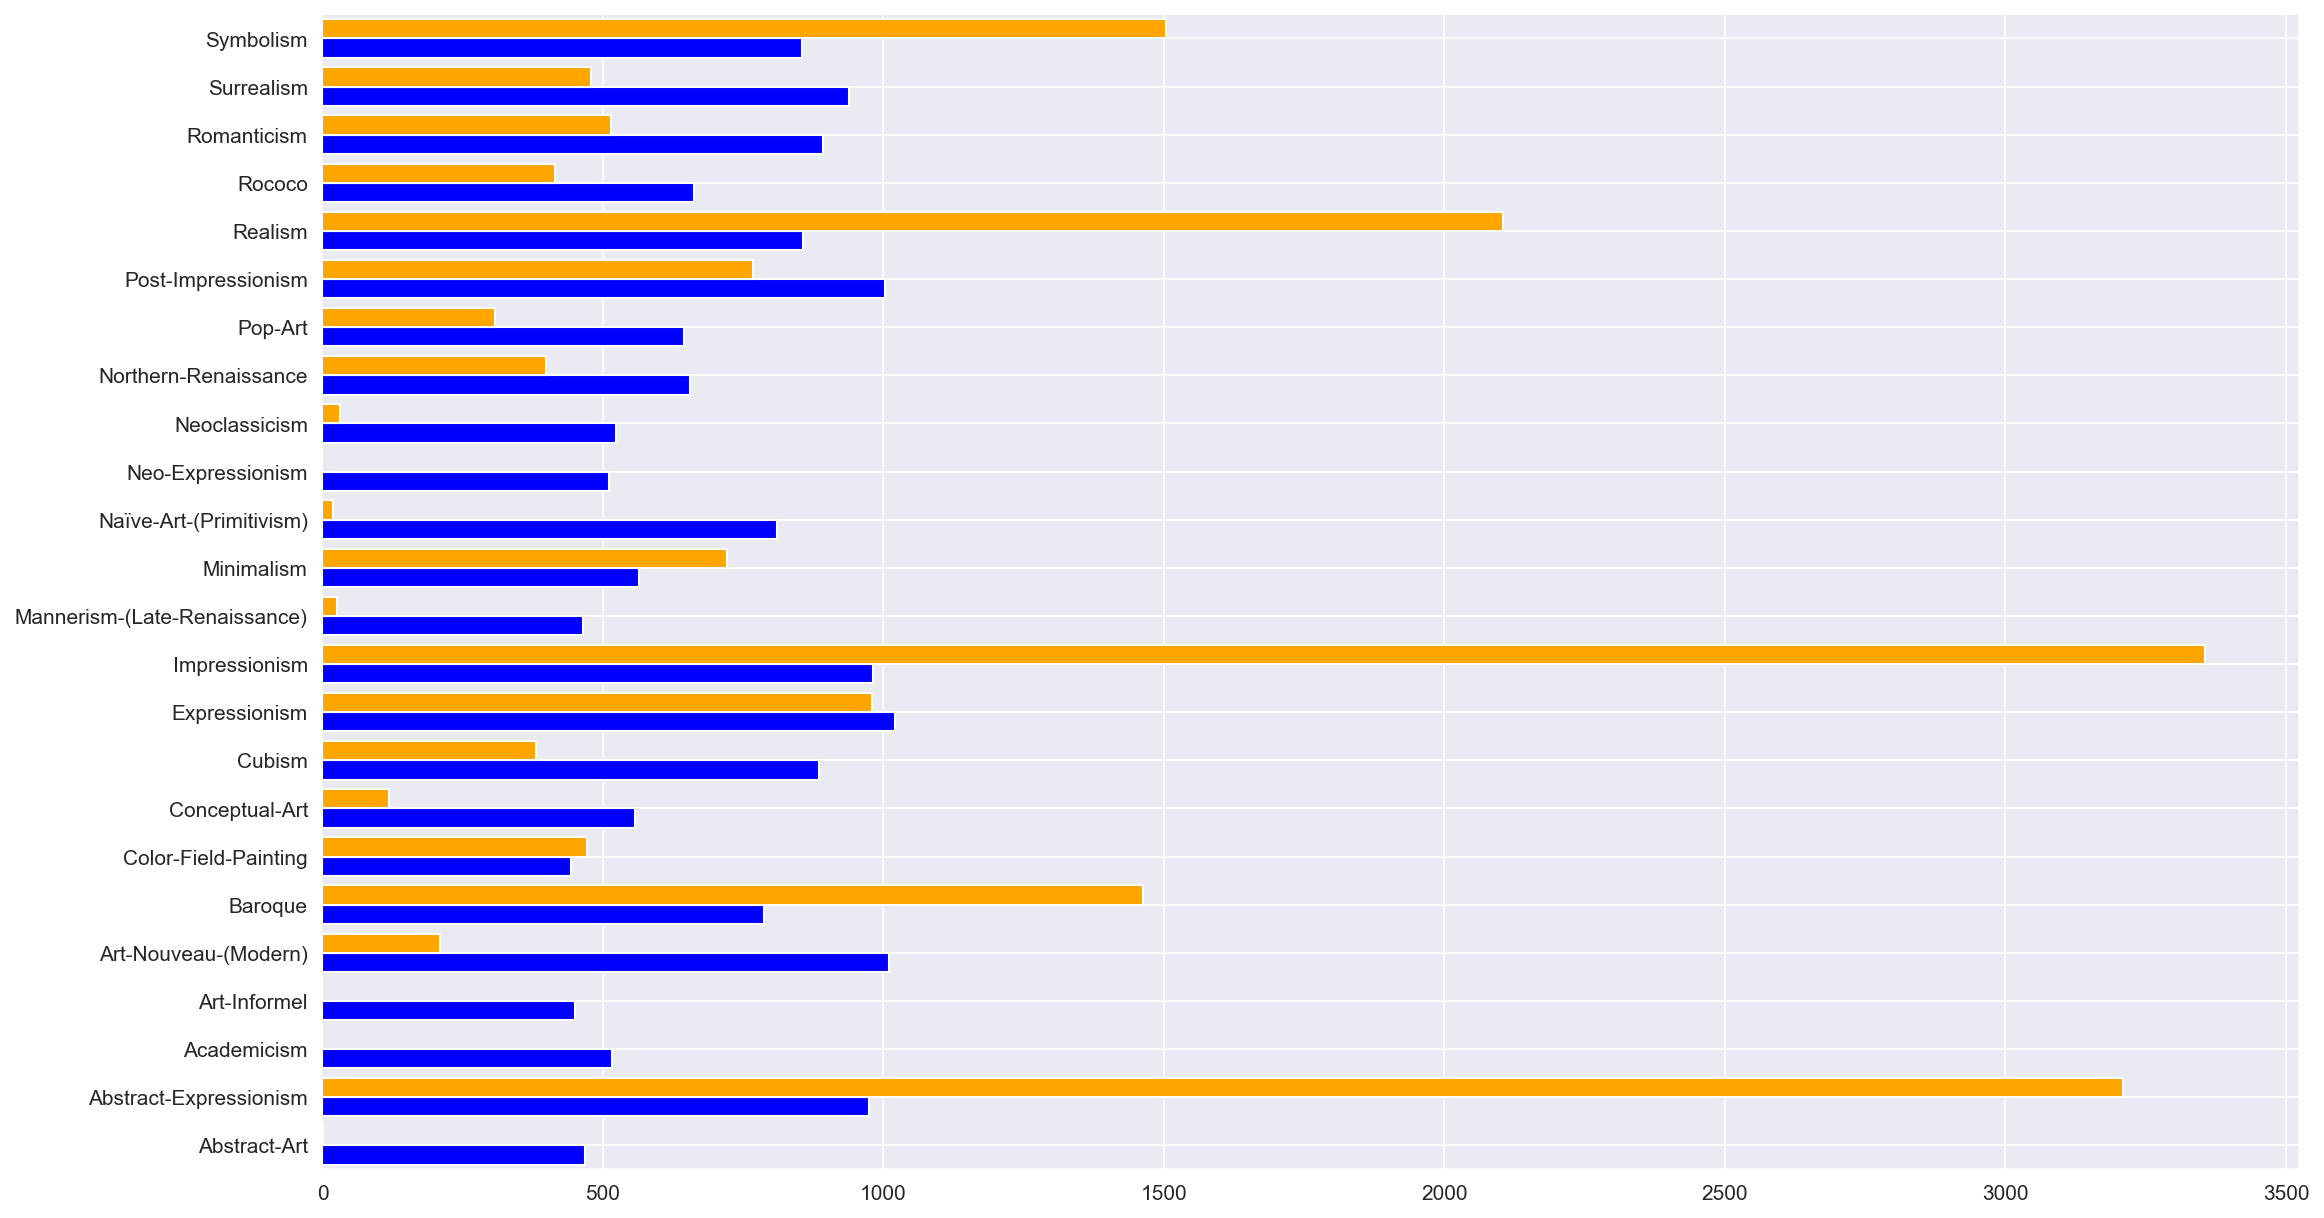

In [167]:
# count occurances and predictions
style_counts = y_test[:,0:len(style_labels)]
style_counts = pd.DataFrame(style_counts, columns=style_labels).astype(int)
style_counts.columns = style_counts.columns.str.replace("Style_", "")
style_counts = style_counts.sum()
#df[style_labels].sum()

style_pred_count = np.zeros_like(style_predictions)
style_pred_count[np.arange(len(style_predictions)), style_predictions.argmax(1)] = 1
style_pred_count = pd.DataFrame(style_pred_count, columns=style_labels).astype(int)
style_pred_count.columns = style_pred_count.columns.str.replace("Style_", "")
style_pred_count = style_pred_count.sum()

print(style_counts.sum())
print(style_pred_count.sum())

fig = plt.figure(figsize=(17, 10), dpi=150)
ax = fig.add_subplot()
style_counts.plot(kind='barh', stacked=False, color='blue', align='edge', ax=ax, width=-0.4)
style_pred_count.plot(kind='barh', stacked=False, color='orange', align='edge',width=0.4, ax=ax)
plt.ylim(-0.5, len(style_counts)-0.5)

[Text(0, 0.5, 'Abstract-Art'),
 Text(0, 1.5, 'Abstract-Expressionism'),
 Text(0, 2.5, 'Academicism'),
 Text(0, 3.5, 'Art-Informel'),
 Text(0, 4.5, 'Art-Nouveau-(Modern)'),
 Text(0, 5.5, 'Baroque'),
 Text(0, 6.5, 'Color-Field-Painting'),
 Text(0, 7.5, 'Conceptual-Art'),
 Text(0, 8.5, 'Cubism'),
 Text(0, 9.5, 'Expressionism'),
 Text(0, 10.5, 'Impressionism'),
 Text(0, 11.5, 'Mannerism-(Late-Renaissance)'),
 Text(0, 12.5, 'Minimalism'),
 Text(0, 13.5, 'Naïve-Art-(Primitivism)'),
 Text(0, 14.5, 'Neo-Expressionism'),
 Text(0, 15.5, 'Neoclassicism'),
 Text(0, 16.5, 'Northern-Renaissance'),
 Text(0, 17.5, 'Pop-Art'),
 Text(0, 18.5, 'Post-Impressionism'),
 Text(0, 19.5, 'Realism'),
 Text(0, 20.5, 'Rococo'),
 Text(0, 21.5, 'Romanticism'),
 Text(0, 22.5, 'Surrealism'),
 Text(0, 23.5, 'Symbolism')]

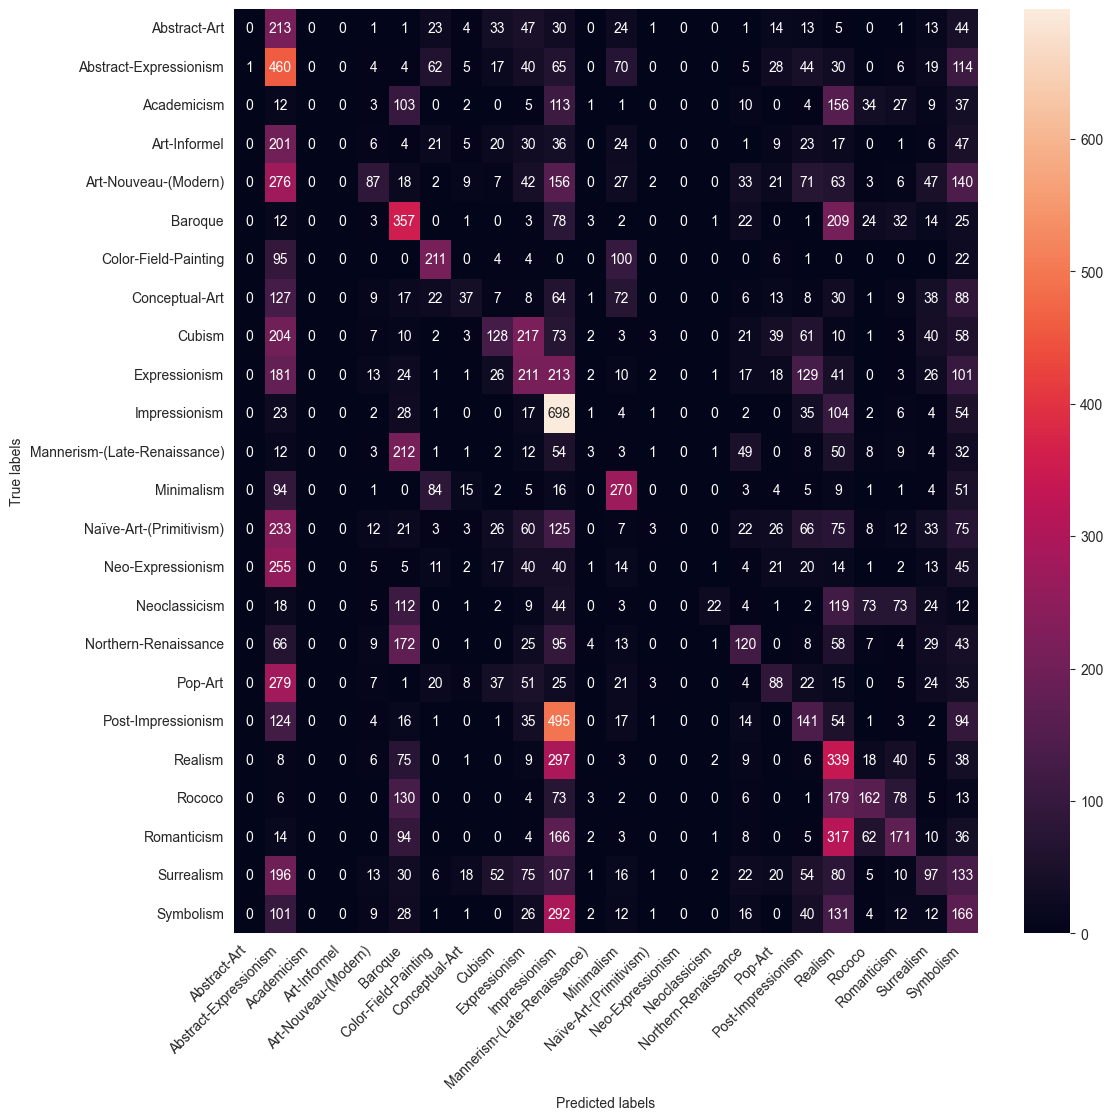

In [175]:

import seaborn as sns

# Plot Style Confusion Matrix
fig = plt.figure(figsize=(12,12))
ax=fig.add_subplot()
sns.heatmap(cm_style, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(map(lambda x: x.replace('Style_',''),style_labels),
                        rotation=45,
                        horizontalalignment='right')
ax.yaxis.set_ticklabels(map(lambda x: x.replace('Style_',''),style_labels))

In [125]:
decade_predictions = model2.predict(load_images(X_test))
cm_decade = confusion_matrix(y_true=y_test[:, len(style_labels):].argmax(axis=1),y_pred=decade_predictions.argmax(axis=1))#, labels=decades)
print(cm_decade)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


17475
17475


(-0.5, 60.5)

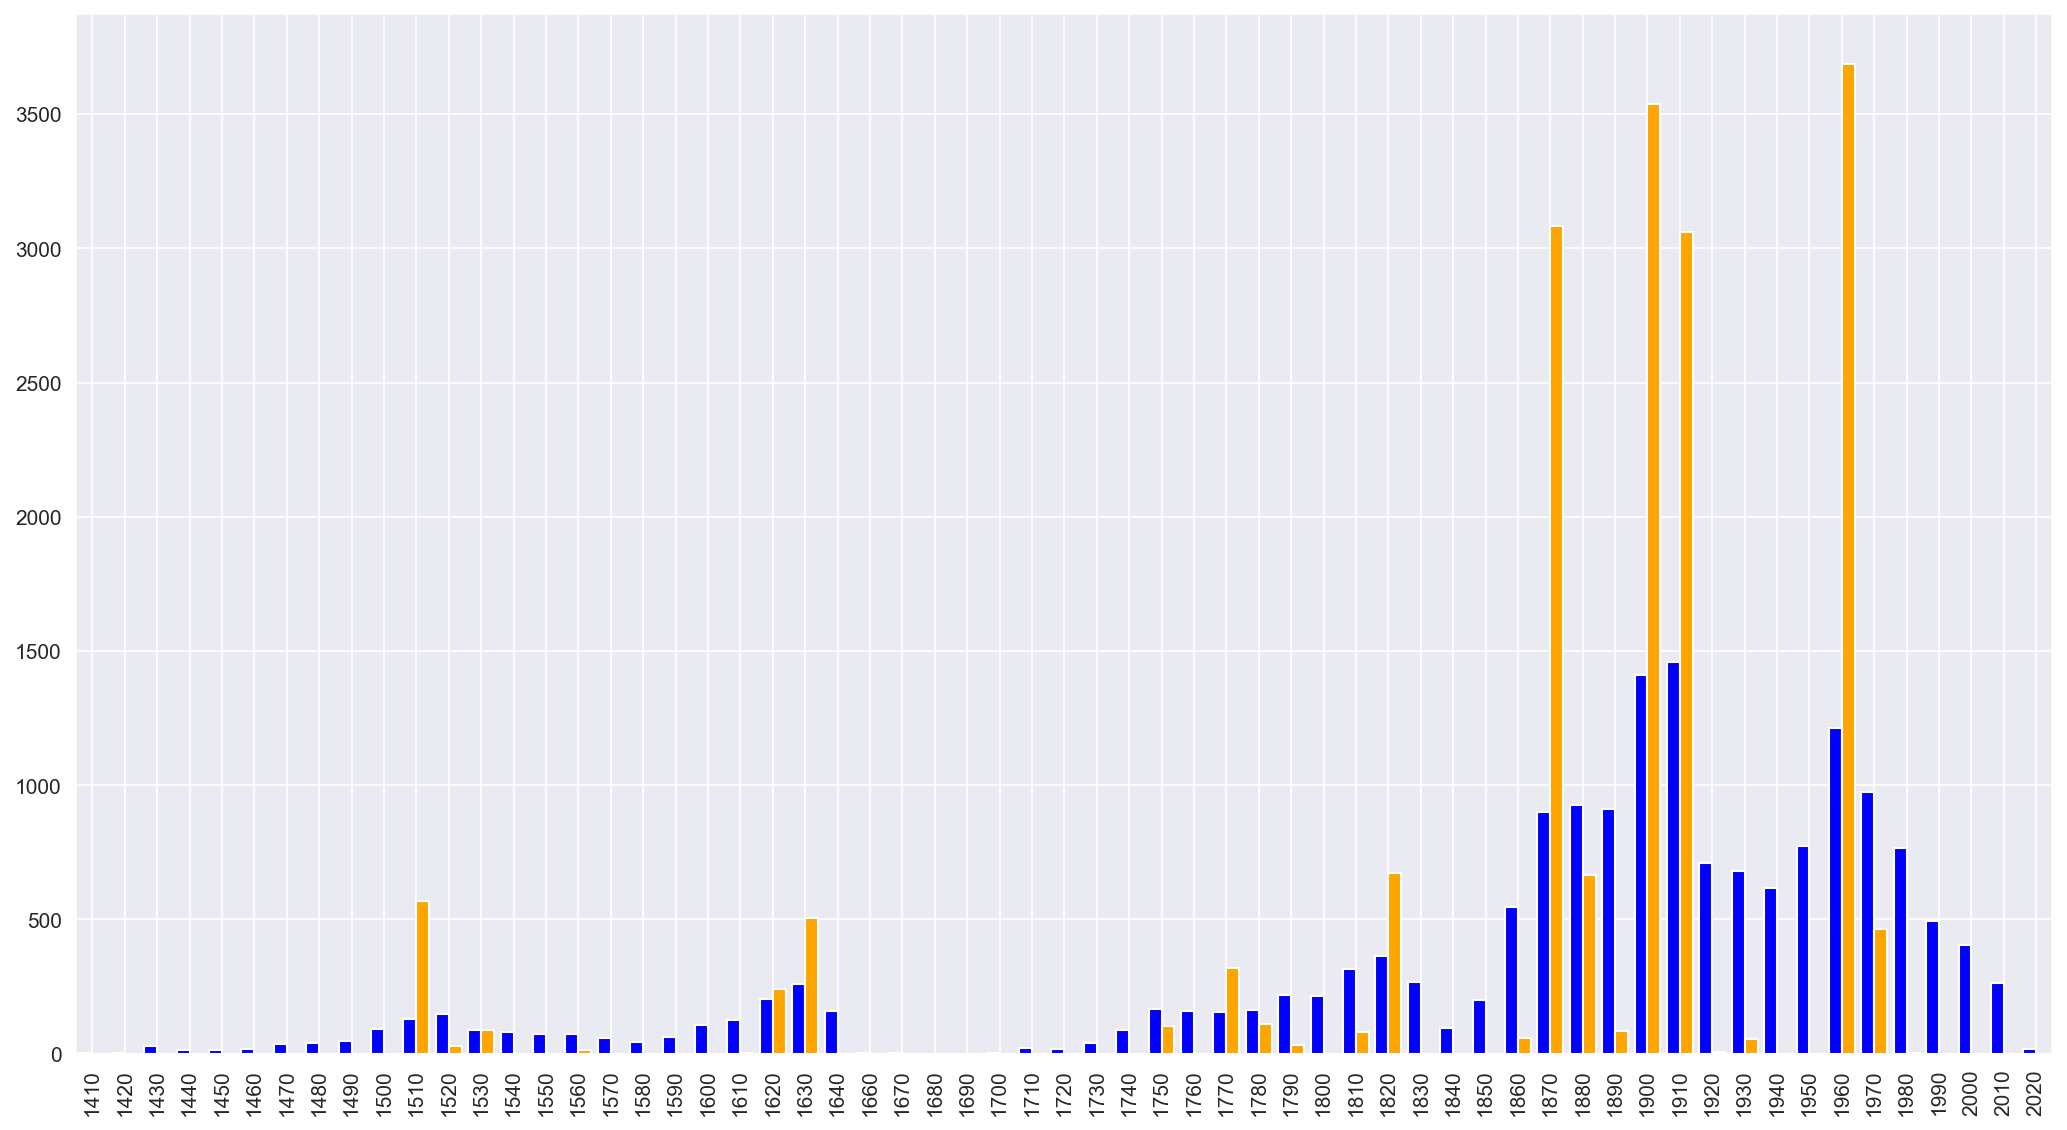

In [149]:
decade_counts = y_test[:,len(style_labels):]
decade_counts = pd.DataFrame(decade_counts, columns=decades).astype(int)
decade_counts.columns = decade_counts.columns.str.replace("Date_", "")
decade_counts = decade_counts.sum()
#df[style_labels].sum()

decade_pred_count = np.zeros_like(decade_predictions)
decade_pred_count[np.arange(len(decade_predictions)), decade_predictions.argmax(1)] = 1
decade_pred_count = pd.DataFrame(decade_pred_count, columns=decades).astype(int)
decade_pred_count.columns = decade_pred_count.columns.str.replace("Date_", "")
decade_pred_count = decade_pred_count.sum()

print(decade_counts.sum())
print(decade_pred_count.sum())

fig = plt.figure(figsize=(17, 9), dpi=150)
ax = fig.add_subplot()
decade_counts.plot(kind='bar', stacked=False, color='blue', align='edge', ax=ax,width=-0.4)
decade_pred_count.plot(kind='bar', stacked=False, color='orange', align='edge',width=0.4, ax=ax)
plt.xlim(-0.5, len(decade_counts)-0.5)

In [127]:
print(cm_decade.shape)
print(decade_predictions.shape)
print(y_test[:, len(style_labels):].shape)

(59, 59)
(17475, 61)
(17475, 61)


[Text(0, -0.5, 'Date_1410'),
 Text(0, 0.5, 'Date_1420'),
 Text(0, 1.5, 'Date_1430'),
 Text(0, 2.5, 'Date_1440'),
 Text(0, 3.5, 'Date_1450'),
 Text(0, 4.5, 'Date_1460'),
 Text(0, 5.5, 'Date_1470'),
 Text(0, 6.5, 'Date_1480'),
 Text(0, 7.5, 'Date_1490'),
 Text(0, 8.5, 'Date_1500'),
 Text(0, 9.5, 'Date_1510'),
 Text(0, 10.5, 'Date_1520'),
 Text(0, 11.5, 'Date_1530'),
 Text(0, 12.5, 'Date_1540'),
 Text(0, 13.5, 'Date_1550'),
 Text(0, 14.5, 'Date_1560'),
 Text(0, 15.5, 'Date_1570'),
 Text(0, 16.5, 'Date_1580'),
 Text(0, 17.5, 'Date_1590'),
 Text(0, 18.5, 'Date_1600'),
 Text(0, 19.5, 'Date_1610'),
 Text(0, 20.5, 'Date_1620'),
 Text(0, 21.5, 'Date_1630'),
 Text(0, 22.5, 'Date_1640'),
 Text(0, 23.5, 'Date_1660'),
 Text(0, 24.5, 'Date_1670'),
 Text(0, 25.5, 'Date_1680'),
 Text(0, 26.5, 'Date_1690'),
 Text(0, 27.5, 'Date_1700'),
 Text(0, 28.5, 'Date_1710'),
 Text(0, 29.5, 'Date_1720'),
 Text(0, 30.5, 'Date_1730'),
 Text(0, 31.5, 'Date_1740'),
 Text(0, 32.5, 'Date_1750'),
 Text(0, 33.5, 'Date_176

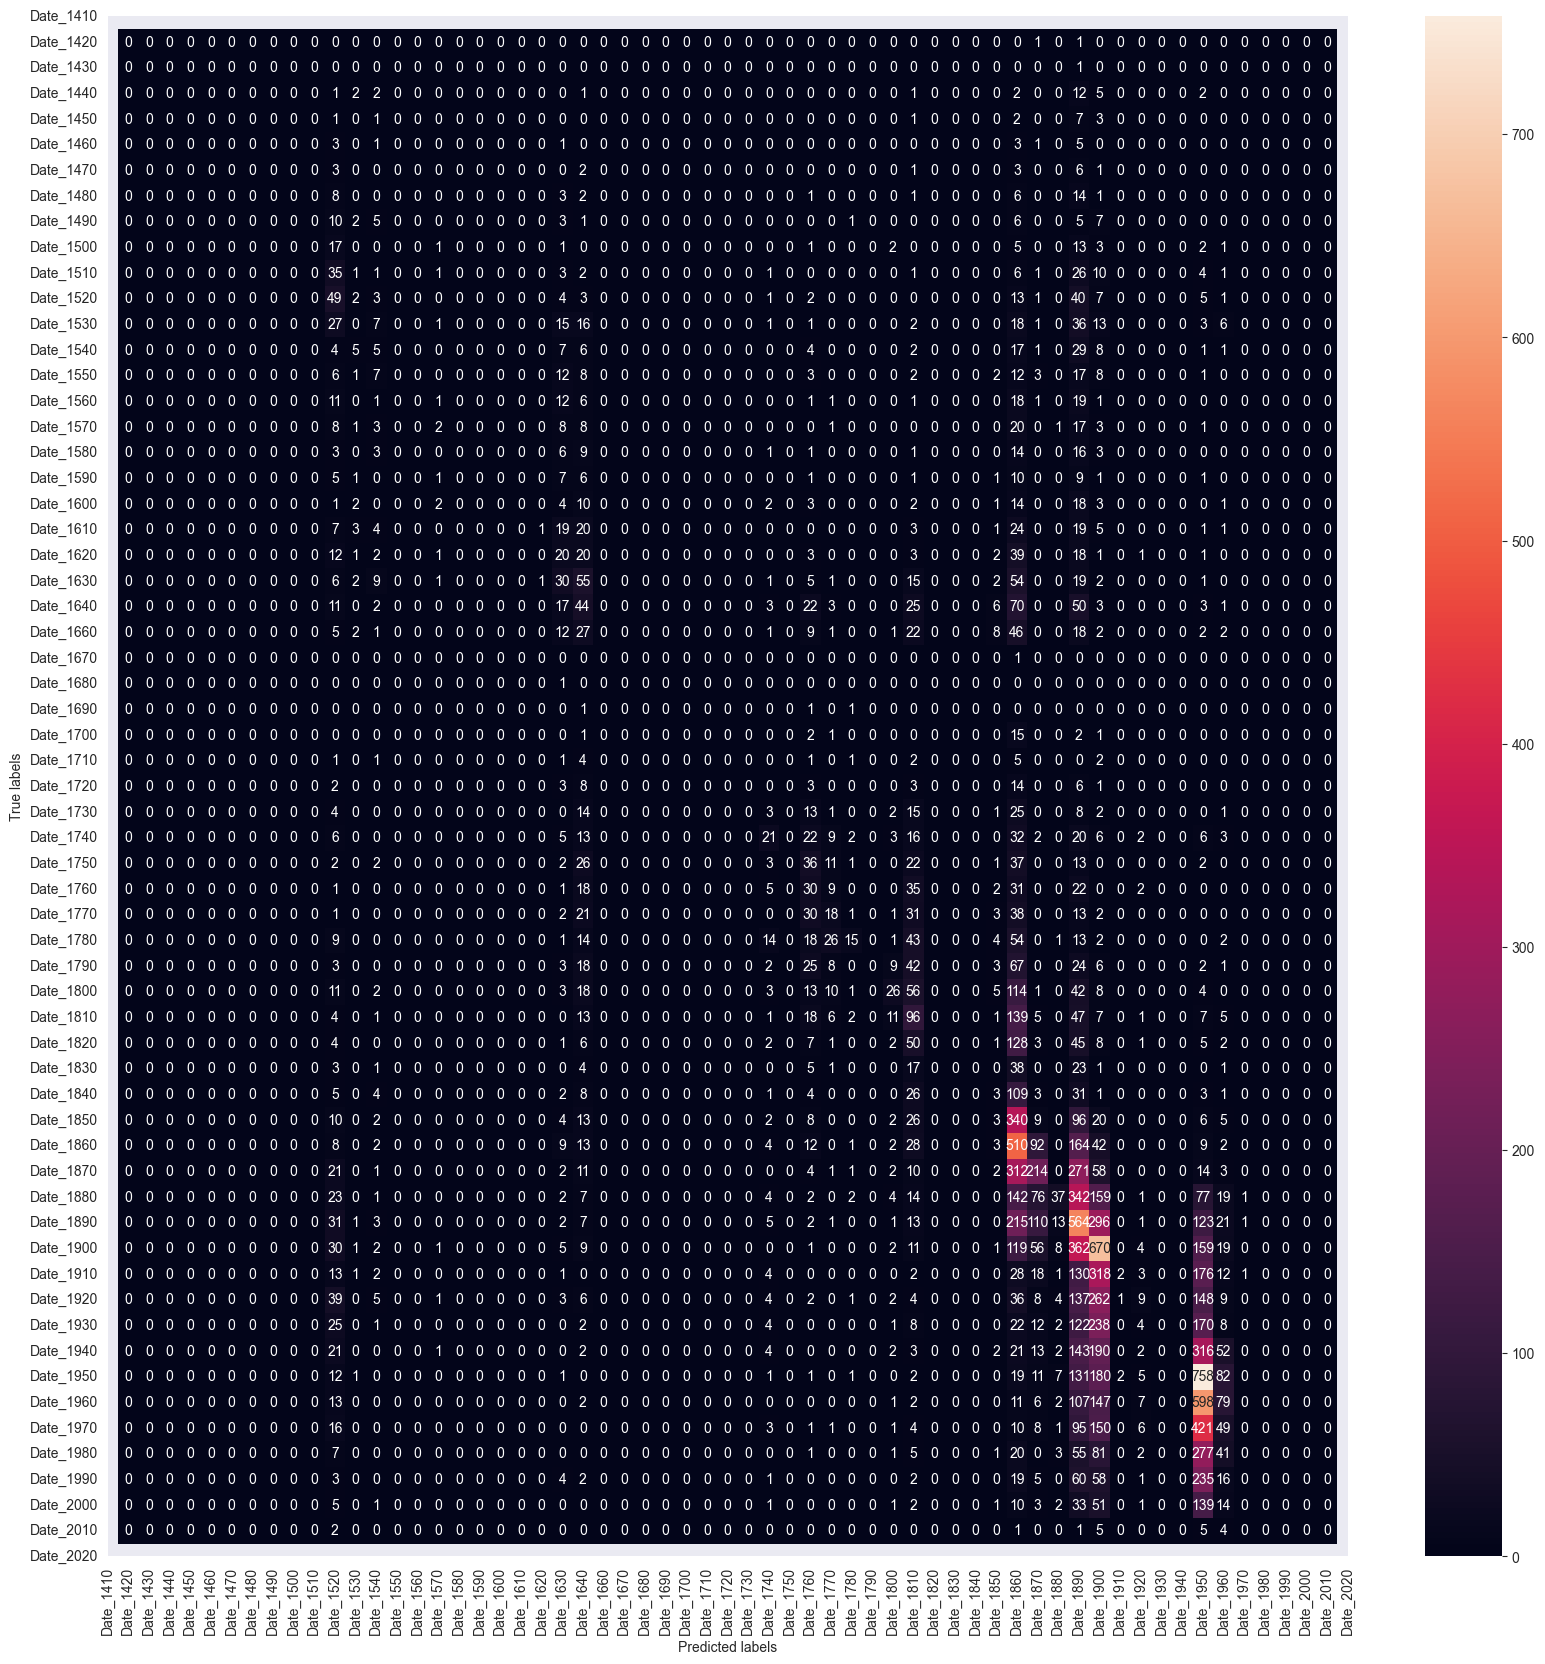

In [112]:
# Plot decades confusion
fig = plt.figure(figsize=(20,20))
ax=fig.add_subplot()
sns.heatmap(cm_decade, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
ax.set_xticks(np.arange(-0.5, len(decades)-0.5, 1))
ax.set_yticks(np.arange(-0.5, len(decades)-0.5, 1))
ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(decades); ax.yaxis.set_ticklabels(decades)

In [35]:
df[["Style_Baroque", "Style_Expressionism", "Style_Impressionism", "Style_Neoclassicism", "Style_Post-Impressionism",
    "Style_Realism", "Style_Romanticism", "Style_Surrealism", "Style_Symbolism"]].apply(pd.Series.value_counts)

,Style_Baroque,Style_Expressionism,Style_Impressionism,Style_Neoclassicism,Style_Post-Impressionism,Style_Realism,Style_Romanticism,Style_Surrealism,Style_Symbolism
0,23412,22618,22766,24371,22675,23158,23061,22868,23207
1,2605,3399,3251,1646,3342,2859,2956,3149,2810


<AxesSubplot: >

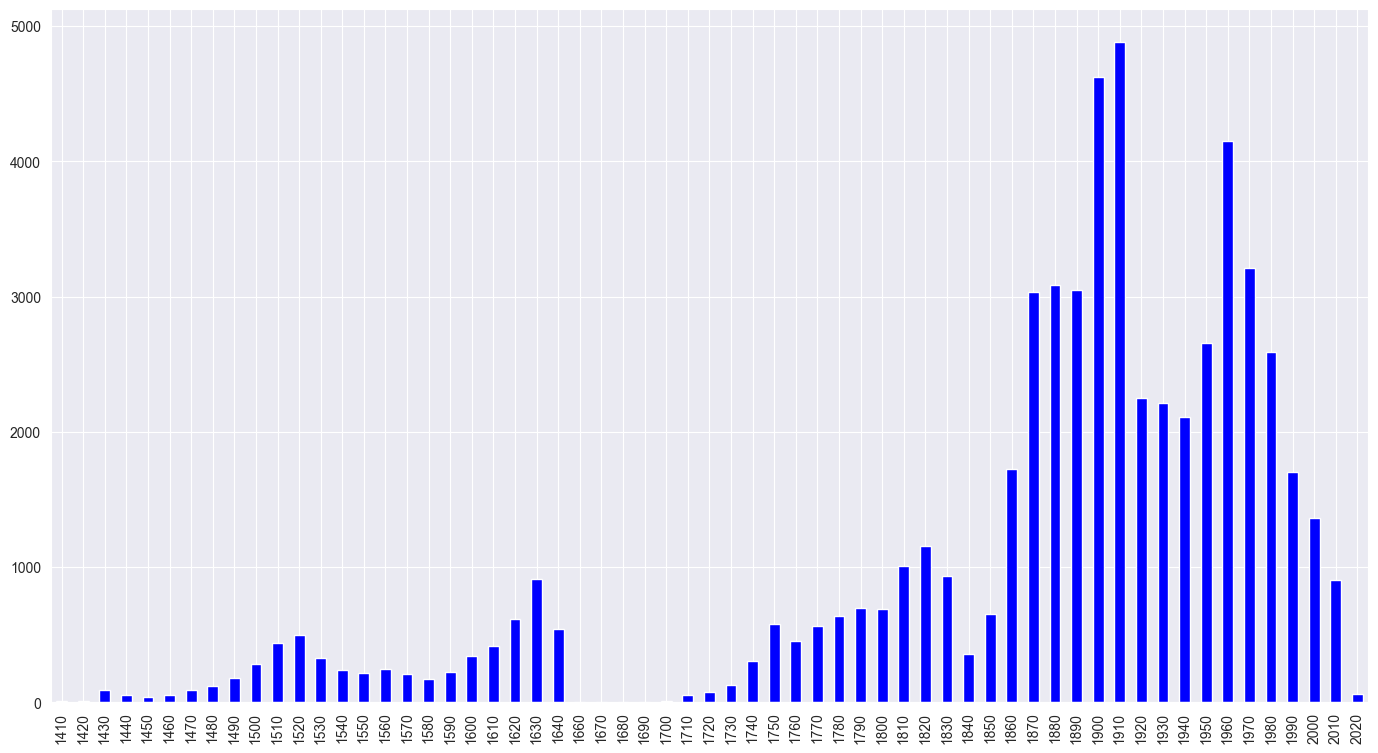

In [160]:
complete_decade_count = df[decades].astype(int)
complete_decade_count.columns = complete_decade_count.columns.str.replace("Date_", "")
complete_decade_count = complete_decade_count.sum()
fig = plt.figure(figsize=(17,9))
complete_decade_count.plot(kind='bar', color='blue')

In [ ]:
# Two separate models
newModel = True
if newModel:
    input_layer = Input(shape=(SIZE,SIZE,3))

    conv1 = Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_layer)
    bn1 = BatchNormalization()(conv1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    dropout1 = Dropout(0.2)(mp1)

    conv2 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(dropout1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    bn2 = BatchNormalization()(mp2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(dropout2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    bn3 = BatchNormalization()(mp3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(dropout3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    bn4 = BatchNormalization()(mp4)
    dropout4 = Dropout(0.2)(bn4)

    flatten = Flatten()(dropout4)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout5 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout5)
    dropout6 = Dropout(0.5)(dense2)

    y1_output = Dense(len(styles), activation='softmax', name='style_output')(dropout6)
    y2_output = Dense(len(decades), activation='softmax', name='decade_output')(dropout6)
    #model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    model_style = keras.Model(inputs=input_layer, outputs=y1_output)
    model_time = keras.Model(inputs=input_layer, outputs=y2_output)


    model_style.summary()
    model_time.summary()


    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model_style.compile(optimizer='adam',
                  loss={'style_output':'binary_crossentropy', 'decade_output':'binary_crossentropy'},
                  metrics={'style_output':'accuracy','decade_output':'accuracy'})


    history_style = model_style.fit(X_train,
                        y_train[:,0:len(styles)],
                        epochs=5,
                        validation_data=(X_test, y_test[:,0:len(styles)]),
                        batch_size=64,
                        callbacks=[csv_logger])

    # save model
    !mkdir -p saved_model
    model_style.save('saved_model/style_model')

else:
    model = keras.models.load_model('saved_model/my_model_with_years')
    #history = model.evaluate(X_test, y_test, verbose=2)
    #history.history=history

In [193]:
#np.savetxt('history_decades.csv', history)